In [1]:
import warnings
warnings.filterwarnings("ignore")
import gymnasium as gym

import os
import sys

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
import traci

from sumo_rl import SumoEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import numpy as np
import random
import math
from torch.distributions import Categorical, MultivariateNormal
from itertools import count


# set up matplotlib
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env = SumoEnvironment(
        net_file="nets/2way-single-intersection/single-intersection.net.xml",
        route_file="nets/2way-single-intersection/single-intersection-vhvh.rou.xml",
        single_agent=True,
        use_gui=False,
        num_seconds=100,
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [3]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
    def act(self, state):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):
      
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def select_action(self, state):

        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)
            
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


In [4]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

lr_actor = 0.0003
lr_critic = 0.001
gamma = 0.99
K_epochs = 40
eps_clip = 0.2

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

In [5]:
num_episodes = 1000
episode_rewards = []

for i_episode in range(num_episodes):
    state, info = env.reset()
    episode_reward = 0
    for t in count():
        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        ppo_agent.buffer.rewards.append(reward)
        done = terminated or truncated
        ppo_agent.buffer.is_terminals.append(done)
        if done:
            break
        

    ppo_agent.update()
    
    episode_rewards.append(episode_reward)

 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 151ms, vehicles TOT 74 ACT 36 BUF 0)                  
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 69ms, vehicles TOT 74 ACT 46 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 61ms, vehicles TOT 74 ACT 35 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 64ms, vehicles TOT 74 ACT 31 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 61ms, vehicles TOT 74 ACT 40 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 59ms, vehicles TOT 74 ACT 31 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 59ms, vehicles TOT 74 ACT 29 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 60ms, vehicles TOT 74 ACT 34 BUF 0)                   
 Retrying in 1 seconds
Step #100.00 (0ms ?*RT. ?UPS, TraCI: 64ms, vehicles TOT 7

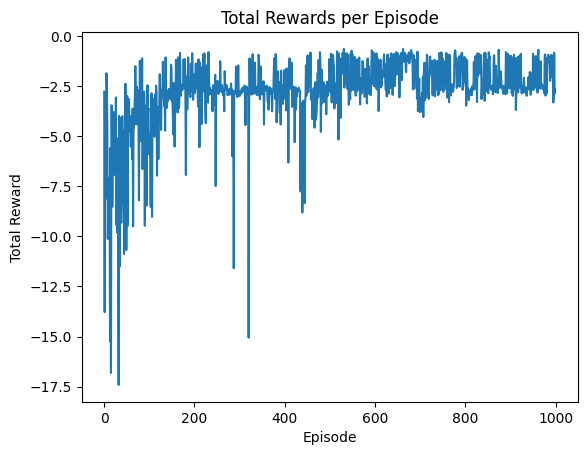

In [6]:
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode')
plt.show()